In [52]:
# Análisis Exploratorio de Datos - Demanda Energética Cuba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

In [53]:
def load_and_prepare_data(file_path):
    """Carga y prepara los datos iniciales"""
    df = pd.read_csv(file_path)
    
    # Convertir fecha a datetime
    df['fecha'] = pd.to_datetime(df['fecha'])
    
    # Crear variables derivadas adicionales
    df['deficit_real'] = df['demanda_maxima'] - df['disponibilidad_total']
    df['margen_seguridad'] = df['disponibilidad_total'] - df['demanda_maxima']
    df['eficiencia_07am'] = df['disponibilidad_07am'] / df['disponibilidad_total'] * 100
    df['utilizacion_07am'] = df['demanda_07am'] / df['disponibilidad_07am'] * 100
    
    # Categorizar días
    df['tipo_dia'] = df['dia_semana'].map({
        0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves',
        4: 'Viernes', 5: 'Sábado', 6: 'Domingo'
    })
    
    return df


file_path = '../data/processed/cleaned_energy_data.csv'
df = load_and_prepare_data(file_path)


In [54]:
# Prueba ADF para 'demanda_maxima'
result = adfuller(df['demanda_maxima'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-valor: {result[1]}')
print('Valores críticos:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -3.57101620978446
p-valor: 0.006339933146099431
Valores críticos:
   1%: -3.4399324443722814
   5%: -2.865768564020576
   10%: -2.5690218258831052



Gráfico guardado como 'grafico_energia.png'


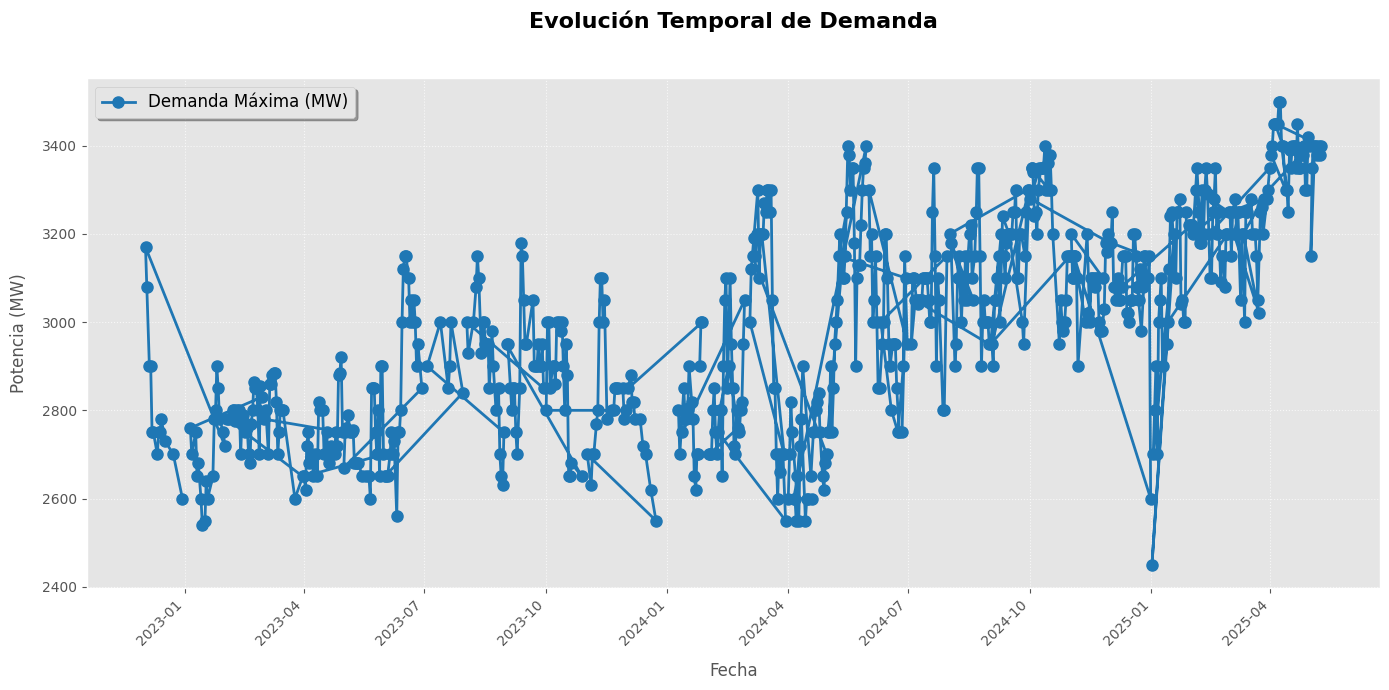

In [55]:

# 3. Configuración del gráfico
plt.figure(figsize=(14, 7))
plt.style.use('ggplot')  # Estilo moderno (opcional)

# 4. Crear el gráfico de líneas principal
# Demanda máxima
plt.plot(df['fecha'], df['demanda_maxima'], 
         marker='o', markersize=8, linestyle='-', linewidth=2, color='#1f77b4',
         label='Demanda Máxima (MW)')



# 5. Personalización avanzada del gráfico
plt.title('Evolución Temporal de Demanda\n', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Fecha', fontsize=12, labelpad=10)
plt.ylabel('Potencia (MW)', fontsize=12, labelpad=10)

# Configurar ejes
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12, framealpha=1, shadow=True)

# Formatear fechas en el eje x
plt.gcf().autofmt_xdate(rotation=45)
plt.tight_layout()

# 6. Mostrar y guardar el gráfico
plt.savefig('grafico_energia.png', dpi=300, bbox_inches='tight', transparent=False)
print("\nGráfico guardado como 'grafico_energia.png'")
plt.show()

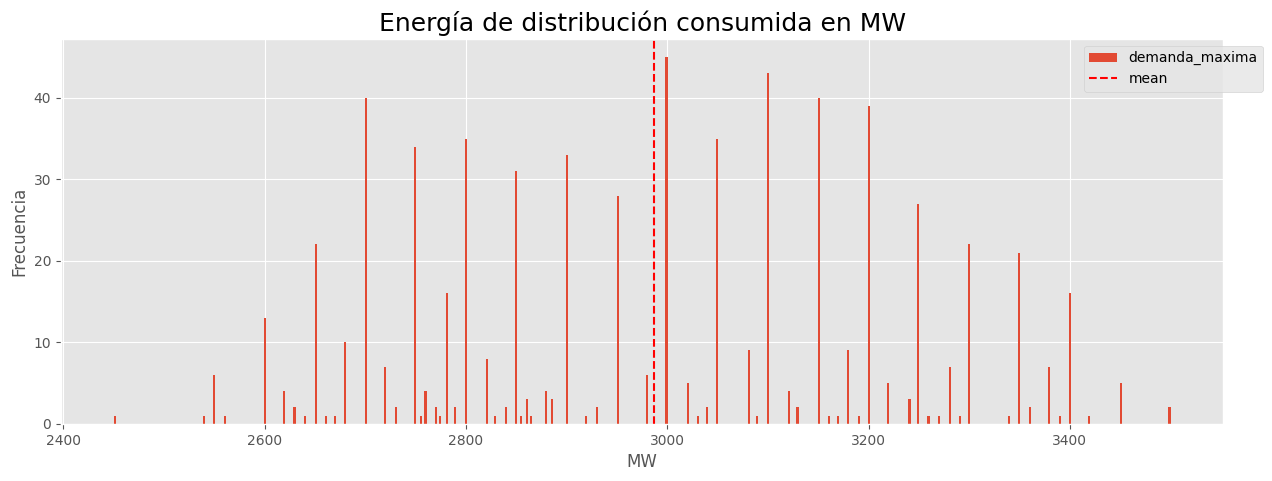

In [56]:
mean_MW = df['demanda_maxima'].mean()
mean_MW

df['demanda_maxima'].plot(figsize = (15,5), kind = 'hist', bins = 500)

plt.title('Energía de distribución consumida en MW', fontsize=18)

plt.xlabel('MW', fontsize=12)

plt.ylabel('Frecuencia', fontsize=12)

plt.axvline(x=mean_MW, color='r', linestyle = '--', label = 'mean')

plt.legend(bbox_to_anchor=(1.04,1))

In [57]:
# Asegurar que el DataFrame esté ordenado por fecha
df = df.sort_index()

# Configurar TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3,test_size=30,gap=7,max_train_size=200)

for train_index, val_index in tss.split(df):
    print(f"Train: {len(train_index)}, Val: {len(val_index)}")


Train: 200, Val: 30
Train: 200, Val: 30
Train: 200, Val: 30


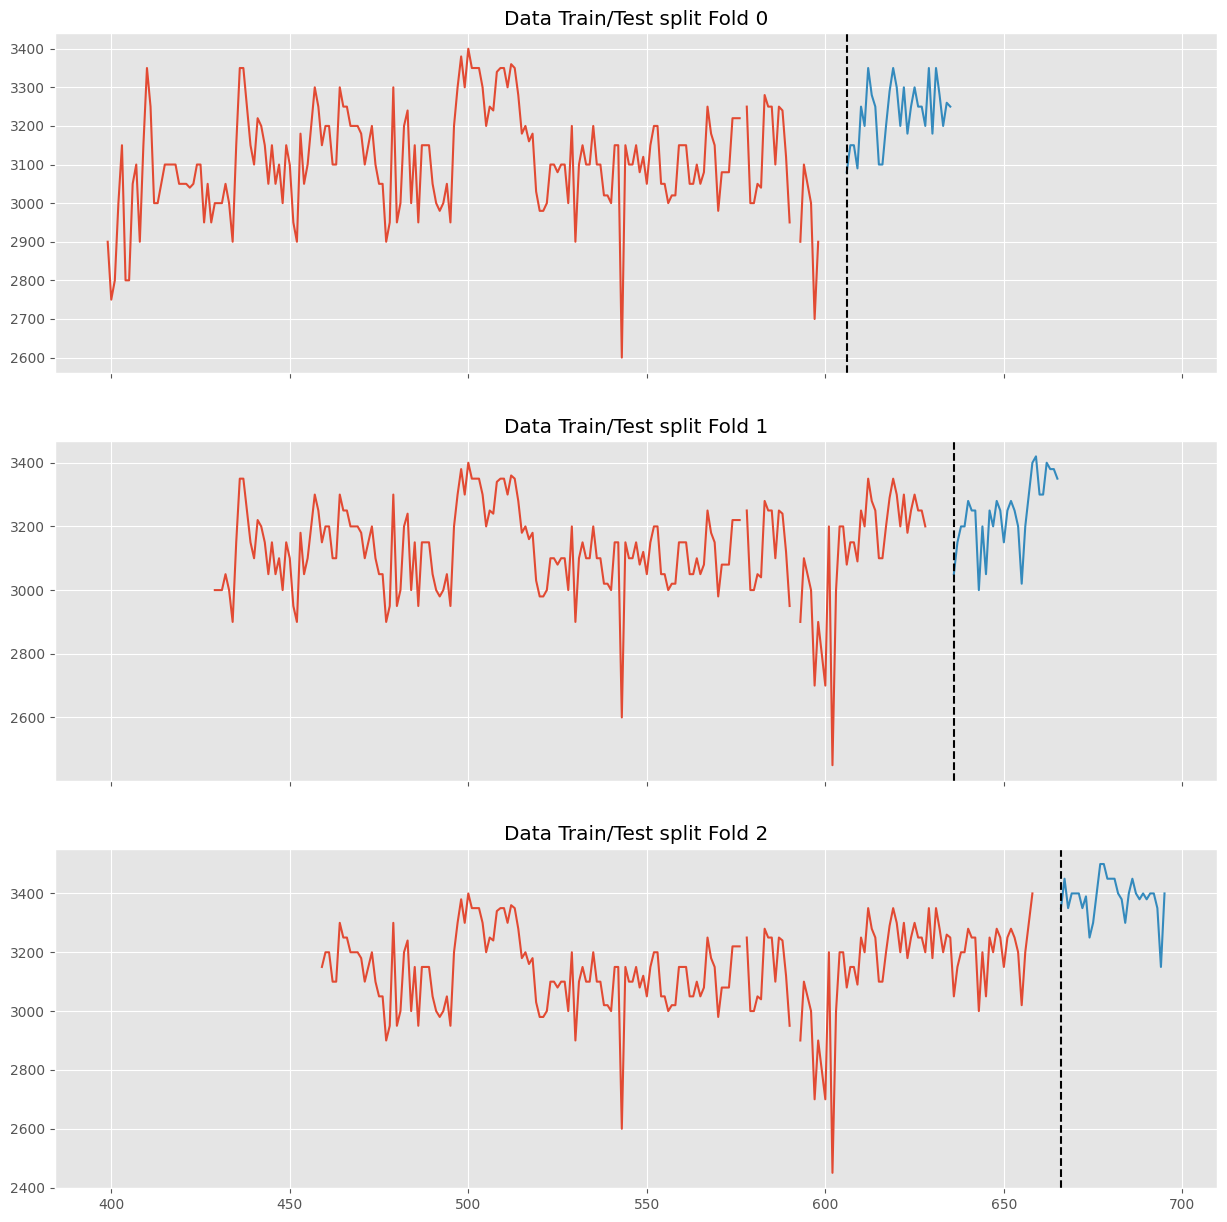

In [58]:
fig, axs = plt.subplots(3, 1,figsize = (15,15), sharex=True)

fold = 0
for train_index, val_index in tss.split(df):
    train =df.iloc[train_index]
    test = df.iloc[val_index]
    train['demanda_maxima'].plot(ax = axs[fold],
                         label = 'Training Set',
                         title = f'Data Train/Test split Fold {fold}')
    test['demanda_maxima'].plot(ax = axs[fold], label = 'Test Set')
    
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold += 1

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Cargar y preparar tus datos

df = df.set_index('fecha').sort_index()

FEATURES = ['hora', 'dia_semana', 'es_fin_semana', 'mes', 'año', 'demanda_07am', 'deficit_real']
TARGET = 'demanda_maxima'

df = df.dropna(subset=[TARGET])
X = df[FEATURES]
y = df[TARGET]

# 2. Inicializar TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3)

# 3. Visualización + entrenamiento
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, val_index in tss.split(df):
    # Dividir datos
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Entrenar modelo
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=42,
        tree_method='hist'
    )
    model.fit(X_train, y_train)

    # Predecir
    y_pred = model.predict(X_val)

    # Métricas
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    print(f"\nFold {fold}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")

    # Visualización
    df.iloc[train_index][TARGET].plot(ax=axs[fold], label='Train', title=f'Data Train/Test Split - Fold {fold}')
    df.iloc[val_index][TARGET].plot(ax=axs[fold], label='Test')
    axs[fold].plot(df.iloc[val_index].index, y_pred, label='Predicho', color='red', linestyle='--', alpha=0.6)
    axs[fold].axvline(df.iloc[val_index].index.min(), color='black', ls='--')
    axs[fold].legend()
    
    fold += 1

plt.tight_layout()
plt.show()


KeyError: "['hora', 'deficit_real'] not in index"

[0]	validation_0-mae:553.78003
[100]	validation_0-mae:400.19995
[200]	validation_0-mae:342.24512
[300]	validation_0-mae:317.27148
[400]	validation_0-mae:305.87244
[500]	validation_0-mae:300.65564
[600]	validation_0-mae:298.27771
[700]	validation_0-mae:296.81140
[800]	validation_0-mae:296.06519
[900]	validation_0-mae:295.76208
[1000]	validation_0-mae:295.58679
[1100]	validation_0-mae:295.44446
[1200]	validation_0-mae:295.40344
[1300]	validation_0-mae:295.38000
[1400]	validation_0-mae:295.36292
[1499]	validation_0-mae:295.34851

Métricas (Entrenamiento):
MAE: 0.0093
RMSE: 0.0120
R²: 1.0000
Error %: 0.0003

Métricas (Prueba):
MAE: 295.3483
RMSE: 299.9401
R²: -34.9856
Error %: 8.5407


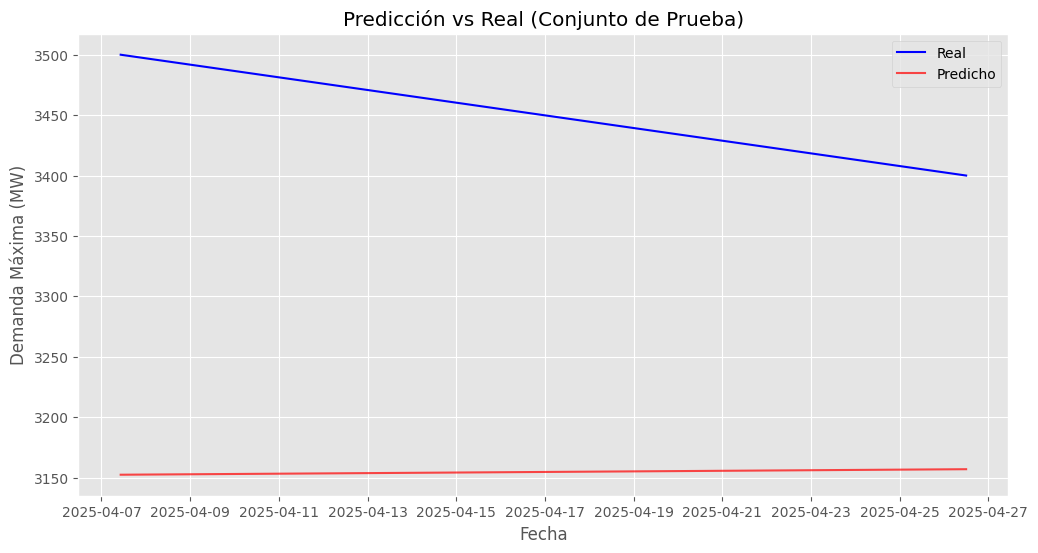

In [62]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import (mean_absolute_error, 
                           mean_squared_error, 
                           r2_score)
import pandas as pd




df = df.dropna(subset=['demanda_maxima'])

# 3. Definir variables
FEATURES = ['hora', 'dia_semana', 'es_fin_semana', 'mes', 'año', 'demanda_07am', 'deficit_real']
TARGET = 'demanda_maxima'

df = df[df[TARGET].notna()]
X = df[FEATURES]
y = df[TARGET]

# 4. División temporal  Usar los últimos 3 meses (20%) para test
test_size = int(len(df) * 0.2)  
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

# Usar los últimos 3 meses (20%) para test
test_size = int(len(df) * 0.2)  
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

# 3. Modelo XGBoost optimizado para series temporales
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1500,  # Aumentado para capturar patrones temporales
    learning_rate=0.02,  # Reducido para mejor generalización
    max_depth=4,  # Profundidad balanceada
    subsample=0.7,  # Más bajo para datos irregulares
    colsample_bytree=0.7,
    early_stopping_rounds=50,  # Mayor paciencia
    eval_metric='mae',
    random_state=42,
    tree_method='hist'  # Más eficiente para datos medianos
)

# 4. Entrenamiento con validación incorporada
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

# 5. Evaluación profesional
def evaluate_model(y_true, y_pred, set_name):
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R²': r2_score(y_true, y_pred),
        'Error %': np.mean(np.abs((y_true - y_pred)/y_true))*100
    }
    print(f"\nMétricas ({set_name}):")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")
    return metrics

train_metrics = evaluate_model(y_train, model.predict(X_train), "Entrenamiento")
test_metrics = evaluate_model(y_test, model.predict(X_test), "Prueba")

# 6. Visualización clave (opcional pero recomendado)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Real', color='blue')
plt.plot(y_test.index, model.predict(X_test), label='Predicho', color='red', alpha=0.7)
plt.title('Predicción vs Real (Conjunto de Prueba)')
plt.xlabel('Fecha')
plt.ylabel('Demanda Máxima (MW)')
plt.legend()
plt.grid(True)
plt.show()

Para predecir el déficit energético, es fundamental comparar varios algoritmos de machine learning porque cada uno tiene ventajas y limitaciones ante distintos tipos de datos y relaciones entre variables. La selección de modelos se basa en:

Interpretabilidad: Modelos como la regresión lineal permiten entender el peso de cada variable.

Capacidad de modelar no linealidades: Algoritmos como Random Forest o Support Vector Regression (SVR) capturan relaciones complejas y no lineales.

Robustez ante outliers y datos faltantes: Los modelos de ensamble suelen ser menos sensibles a valores extremos.

Desempeño empírico: Probar varios modelos permite elegir el que mejor se adapte a los datos reales.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Cargar y preparar datos
features = ['disponibilidad_total', 'disponibilidad_07am', 'demanda_maxima', 'demanda_07am','mw_limitacion_termica' ]
X = df[features]
y = df['deficit_real']

# Eliminar filas con valores nulos
X_clean = X.dropna()
y_clean = y[X_clean.index]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluación
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mejores hiperparámetros:', grid_search.best_params_)
print('MSE:', mse)
print('R²:', r2)


Mejores hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
MSE: 37006.04811666668
R²: 0.9094198232506604
